In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from itertools import groupby

In [2]:
def display_images(images):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis(False)
    

In [3]:
def filter_outlier_15IQR(data):
    data = np.array(data)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return filtered_data

In [52]:
img_path = "./segmentation/col0"
img_list = [file for file in os.listdir(img_path)]
print(img_list)

ori_imgs_path = "./segmentation/original_imgs"
ori_imgs_list = [file for file in os.listdir(ori_imgs_path)]
print(ori_imgs_list)

['W1_Day_20_8-23-23_FastScanner_2FUNU8KDYA_1.png', 'W1_Day_20_8-23-23_FastScanner_N284BGYJRR_1.png', 'W1_Day_20_8-23-23_SlowScanner_AK9E4VGBKN_1.png', 'W2_Day_20_8-30-23_FastScanner_5ZRMCB4II1_1.png', 'W2_Day_20_8-30-23_SlowScanner_36BRUK4TI6_1.png']
['W1_Day_20_8-23-23_FastScanner_2FUNU8KDYA_1.png', 'W1_Day_20_8-23-23_FastScanner_N284BGYJRR_1.png', 'W1_Day_20_8-23-23_SlowScanner_AK9E4VGBKN_1.png', 'W2_Day_20_8-30-23_FastScanner_5ZRMCB4II1_1.png', 'W2_Day_20_8-30-23_SlowScanner_36BRUK4TI6_1.png']


len(raw_images) images with shape of (850, 970, 3)


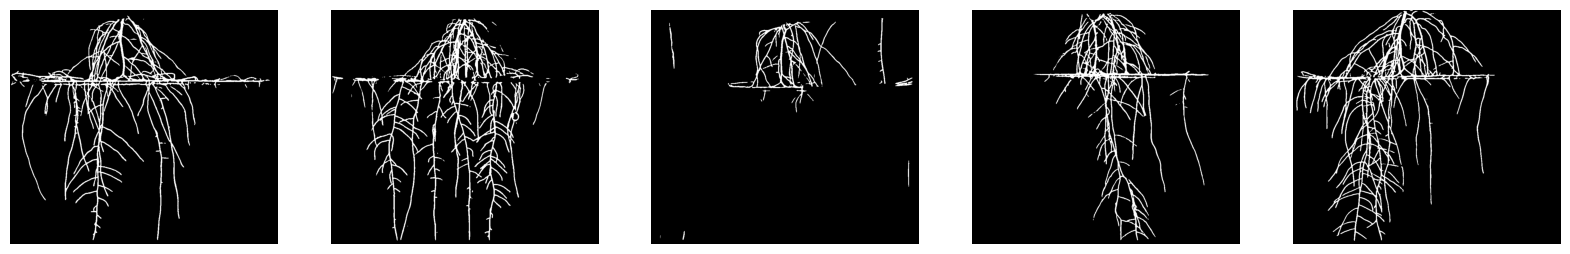

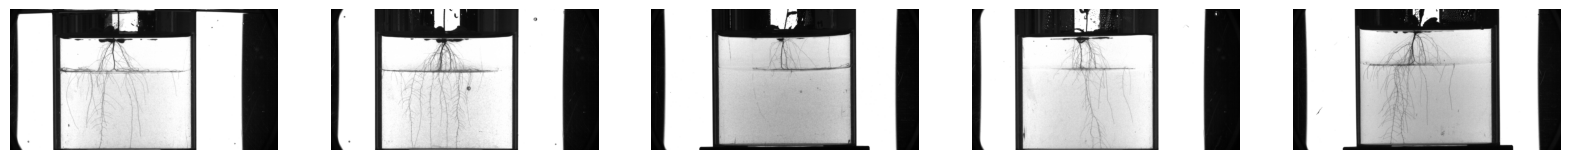

In [41]:
raw_images = [cv2.imread(os.path.join(img_path,file)) for file in img_list]
ori_raw_images = [cv2.imread(os.path.join(ori_imgs_path,file)) for file in ori_imgs_list]

print(f"len(raw_images) images with shape of {raw_images[0].shape}")
display_images(raw_images)
display_images(ori_raw_images)

In [6]:
def show_avg_vert(images):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        avg_v = np.mean(images[i][:,:,0],axis=1) # get avg value for each row
        x_coords = np.arange(len(avg_v))
        indices = [j for j, value in enumerate(avg_v) if value > 5]

        avg_vh = np.mean(images[i][indices[0]:indices[0]+5,:,0],axis=0) # get avg value for each column
        
        
        indicesh = [j for j, value in enumerate(avg_vh) if value > 5]
        indicesh_filter = filter_outlier_15IQR(indicesh) # filter out outliers
        avg_vh_median = np.mean(indicesh_filter) # get mediam value for avg columns
        
        plt.subplot(2, len(images), i + 1)
        plt.scatter(avg_v, x_coords, marker='o', color='blue', label='Data Points')
        plt.gca().invert_yaxis() # descending/inverting y axis

        plt.subplot(2, len(images), len(images)+i+1)
        plt.imshow(images[i])
        plt.axhline(y=indices[0], color='r', linestyle='--')
        plt.axvline(x=avg_vh_median, color='b',linestyle='--')

        save_path = "./segmentation/top"
        plt.savefig(os.path.join(save_path,'save_img.png'))  
        #plt.axis(False)
    

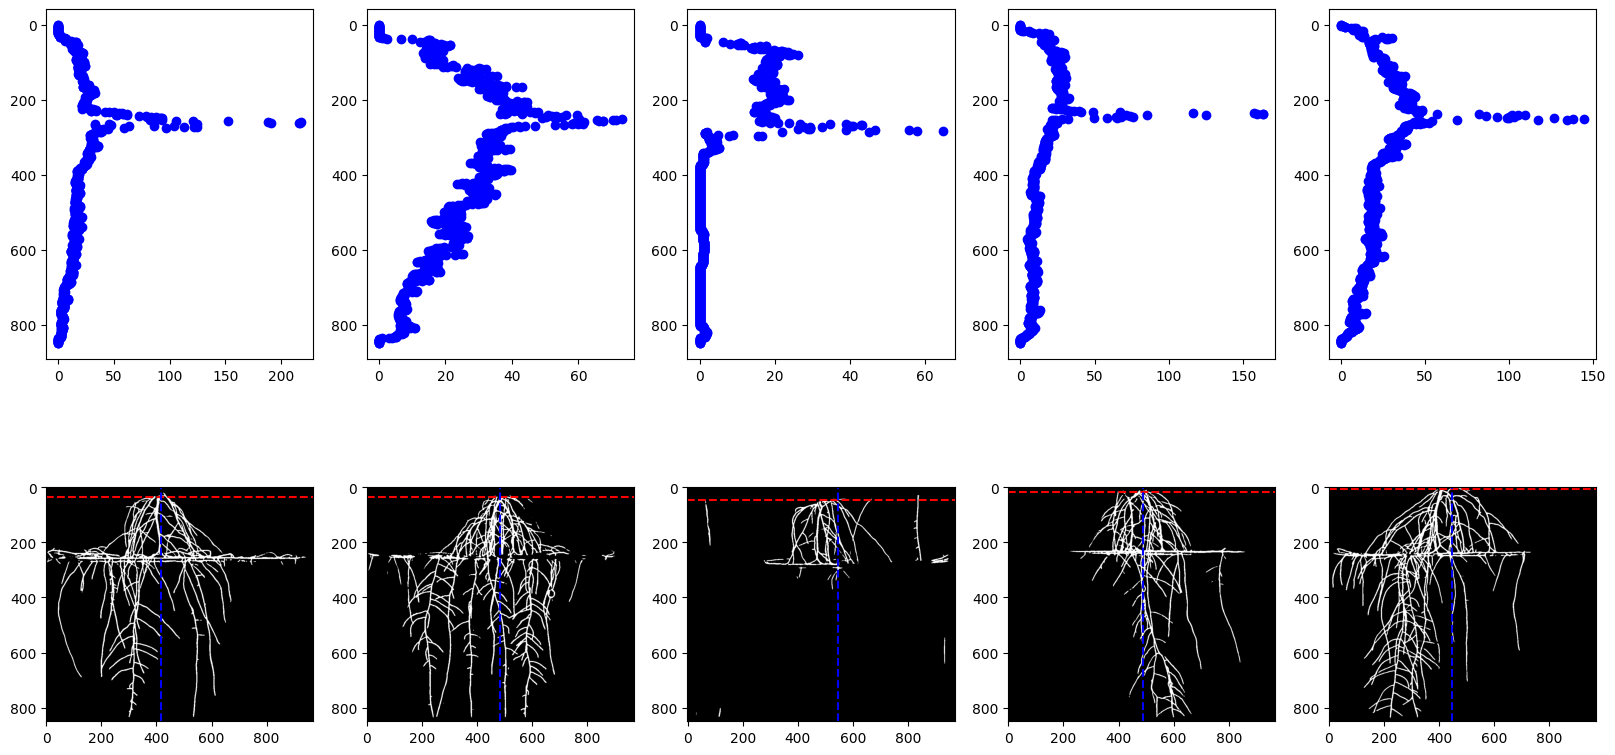

In [7]:
# get the center point of top, where the root starts
show_avg_vert(raw_images)

In [100]:
def get_top_loc(images):
    df = pd.DataFrame(columns=['ind','top_x', 'top_y'])
    for i in range(len(images)):
        avg_v = np.mean(images[i][:,:,0],axis=1) # get avg value for each row
        x_coords = np.arange(len(avg_v))
        indices = [j for j, value in enumerate(avg_v) if value > 5]

        avg_vh = np.mean(images[i][indices[0]:indices[0]+5,:,0],axis=0) # get avg value for each column
        
        indicesh = [j for j, value in enumerate(avg_vh) if value > 5]
        indicesh_filter = filter_outlier_15IQR(indicesh) # filter out outliers
        avg_vh_median = np.mean(indicesh_filter) # get mediam value for avg columns
        
        y = indices[0]
        x=int(avg_vh_median)
        df = pd.concat([df,pd.DataFrame([{'ind':i,'top_x':x,'top_y':y}])], ignore_index=True)
    return df
        
       

In [101]:
df = get_top_loc(raw_images)
df

,ind,top_x,top_y
0,0,415,35
1,1,483,37
2,2,545,46
3,3,489,17
4,4,444,7


In [102]:
# get the top layer segmentation
def seperate_layers_cylinder_penetration(raw_images):
    layer_boundary_threshold = 20
    window_size = 5 # sliding windows for the moving average
    layer_ind_df = pd.DataFrame()

    top = 219 # 180/219
    left = 386 # 526/386
    height = 850
    width = 970

    plt.figure(figsize=(20,10))

    for i in range(len(raw_images)):
        image = raw_images[i]
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        img_crop = img_gray[top:top+height, left+50:left+width-50] # remove the left and right 50 pixels
        img_crop_v = np.mean(img_crop,axis=1)

        plt.subplot(1,len(raw_images),i+1)
        plt.imshow(img_crop,cmap='gray')

        moving_averages = np.convolve(img_crop_v, np.ones(window_size)/window_size, mode='valid')
        ind = np.argmin(moving_averages[150:-50]) + top + int(window_size/2) + 150 # filter out the first 150 rows and last 50 rows
        data = pd.DataFrame([{'ind':i,'layer_ind':ind}])
        layer_ind_df = pd.concat([layer_ind_df,data], ignore_index=True)
    return layer_ind_df

,ind,top_x,top_y,layer_ind
0,0,415,35,478
1,1,483,37,476
2,2,545,46,462
3,3,489,17,456
4,4,444,7,429


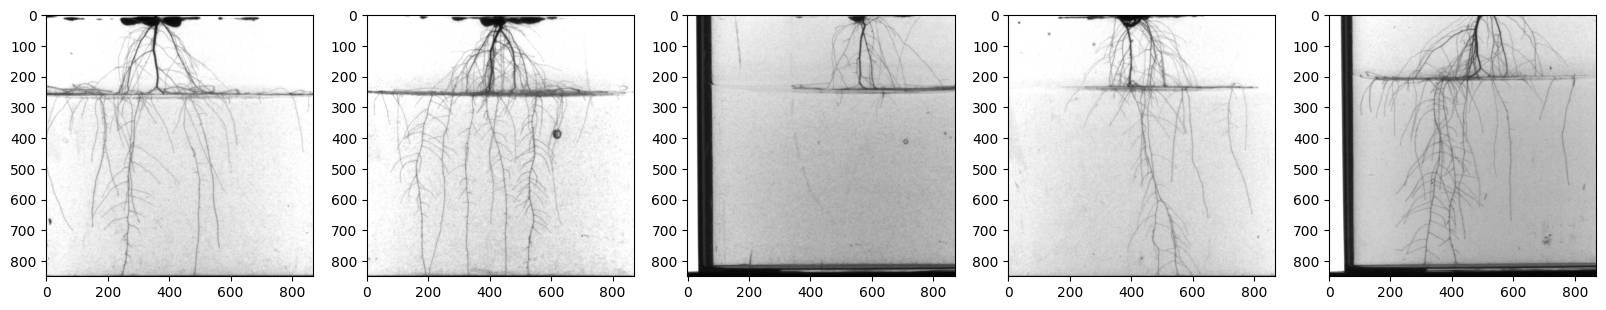

In [103]:
# connect layer_ind_df with df
layer_ind_df = seperate_layers_cylinder_penetration(ori_raw_images)
df_layer = df.merge(layer_ind_df, on='ind', how='left')
df_layer

In [104]:
def draw_seperation_line(raw_images,df):
    plt.figure(figsize=(20,10))
    for i in range(len(raw_images)):
        plt.subplot(1,len(raw_images),i+1)
        plt.imshow(raw_images[i])
        plt.axhline(y=df['layer_ind'][i], color='r', linestyle='--')

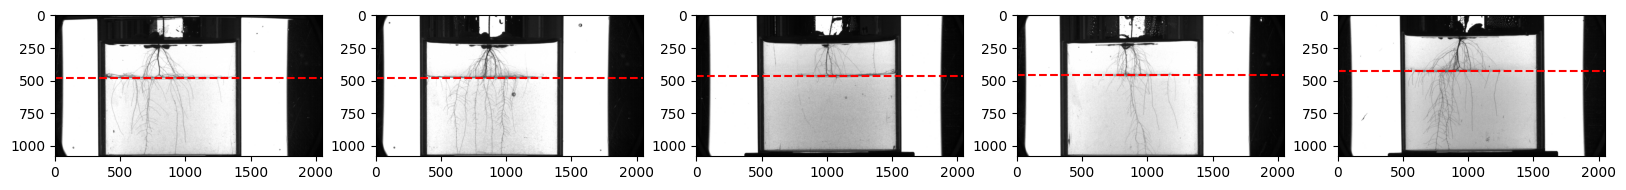

In [105]:
draw_seperation_line(ori_raw_images,df_layer)

In [106]:
# crop the top layers
def crop_top_seg(raw_images,df_layer,top, threshold):
    plt.figure(figsize=(20,10))
    for i in range(len(raw_images)):
        image = raw_images[i]
        height = df_layer['layer_ind'][i] - top - threshold
        img_top = image[:height,:]

        plt.subplot(1,len(raw_images),i+1)
        plt.imshow(img_top)

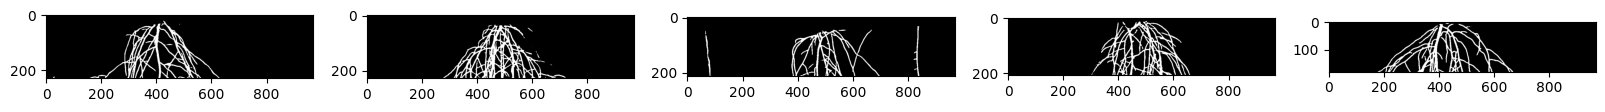

In [107]:
top=219
threshold=30
crop_top_seg(raw_images,df_layer,top, threshold)

In [108]:
heights = df_layer['layer_ind'] - top - threshold
heights

0    229
1    227
2    213
3    207
4    180
Name: layer_ind, dtype: int64

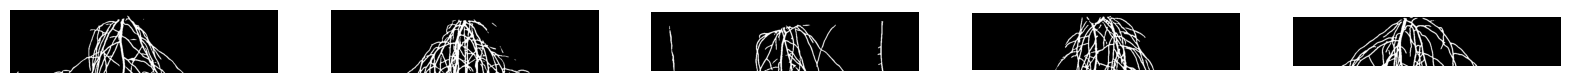

In [109]:
img_tops = [image[:height,:] for image,height in zip(raw_images,heights)]
display_images(img_tops)

# remove the unconnected area?
# remove

In [110]:
left = [np.where(img_top[:,:,0][-1,:] == 255)[0][0] for img_top in img_tops]
right = [np.where(img_top[:,:,0][-1,:] == 255)[0][-1] for img_top in img_tops]
print(f"left index for 5 images: {left}")
print(f"right index for 5 images: {right}")

left index for 5 images: [25, 276, 82, 302, 176]
right index for 5 images: [627, 718, 840, 658, 666]


In [111]:
df_layer['left'] = left
df_layer['right'] = right
df_layer

,ind,top_x,top_y,layer_ind,left,right
0,0,415,35,478,25,627
1,1,483,37,476,276,718
2,2,545,46,462,82,840
3,3,489,17,456,302,658
4,4,444,7,429,176,666


In [112]:
# display angle
def display_angle(img_tops,df_layer,heights):
    plt.figure(figsize=(20,10))
    for i in range(len(img_tops)):
        height = heights[i]
        plt.subplot(1,len(img_tops),i+1)
        plt.imshow(img_tops[i])
        plt.plot([df_layer['top_x'][i],df_layer['left'][i]],[df_layer['top_y'][i],height], color='r', linestyle='-')
        plt.plot([df_layer['top_x'][i],df_layer['right'][i]],[df_layer['top_y'][i],height], color='r', linestyle='-')
        

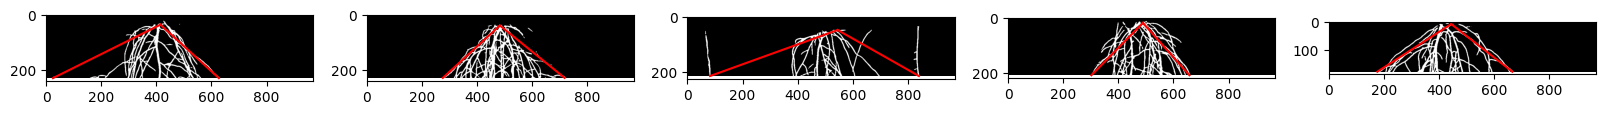

In [113]:
display_angle(img_tops,df_layer,heights)

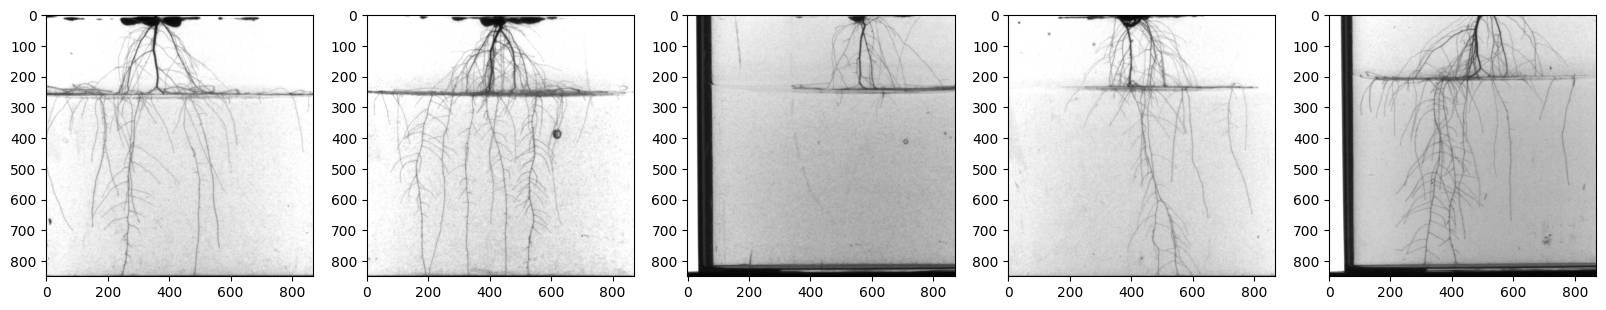

In [114]:
# original images for reference
layer_ind_df = seperate_layers_cylinder_penetration(ori_raw_images)

In [129]:
def get_angle(img_tops,df_layer,heights):
    df = pd.DataFrame()
    for i in range(len(img_tops)):
        height = heights[i]
        vector_left = (height - df_layer['top_y'][i], df_layer['left'][i] - df_layer['top_x'][i])
        vector_right = (height - df_layer['top_y'][i], df_layer['right'][i] - df_layer['top_x'][i])
        angle = math.degrees(math.atan2(vector_right[1], vector_right[0]) - math.atan2(vector_left[1], vector_left[0]))
        df = pd.concat([df,pd.DataFrame([{'ind':i,'angle':angle}])],ignore_index=True)
    return df


In [130]:
angle = get_angle(img_tops,df_layer,heights)
print(angle)

   ind       angle
0    0  111.091144
1    1   98.496066
2    2  130.651801
3    3   86.196326
4    4  109.228304


In [132]:
df_angle = df_layer.merge(angle, on='ind', how='left')
df_angle

,ind,top_x,top_y,layer_ind,left,right,angle
0,0,415,35,478,25,627,111.091144
1,1,483,37,476,276,718,98.496066
2,2,545,46,462,82,840,130.651801
3,3,489,17,456,302,658,86.196326
4,4,444,7,429,176,666,109.228304


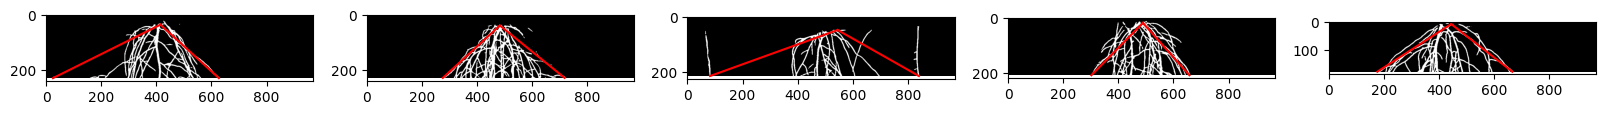

In [133]:
# angle figure for reference
display_angle(img_tops,df_layer,heights)

In [134]:
df_angle['height'] = heights
df_angle

,ind,top_x,top_y,layer_ind,left,right,angle,height
0,0,415,35,478,25,627,111.091144,229
1,1,483,37,476,276,718,98.496066,227
2,2,545,46,462,82,840,130.651801,213
3,3,489,17,456,302,658,86.196326,207
4,4,444,7,429,176,666,109.228304,180


In [196]:
# get root diameters
def get_avg_diameters(img_tops,df_angle):
    plt.figure(figsize=(10,20))
    df = pd.DataFrame()
    for i in range(len(img_tops)): 
        low_layer = img_tops[i][int(df_angle['height'][i]/3*2),:,0] # 2/3 height from top
        high_layer = img_tops[i][int(df_angle['height'][i]/3),:,0] # 1/3 height from top
        x = range(len(low_layer))
        plt.subplot(len(img_tops),2,i*2+1)
        plt.scatter(x,low_layer,s=0.1,c='r')
        plt.subplot(len(img_tops),2,i*2+2)
        plt.scatter(x,high_layer,s=0.1,c='b')

        low_clusters = [sum(1 for _ in group) for key, group in groupby(low_layer) if key == 255]
        print(low_clusters)
        high_clusters = [sum(1 for _ in group) for key, group in groupby(high_layer) if key == 255]
        print(high_clusters)

        low_count, low_diameter = len(low_clusters), np.mean(low_clusters)
        high_count, high_diameter = len(high_clusters), np.mean(high_clusters)
        df = pd.concat([df,pd.DataFrame([{'ind':i,'low_count':low_count,'low_diameter':low_diameter,'high_count':high_count,'high_diameter':high_diameter}])],ignore_index=True)
    return df


[3, 4, 4, 5, 7, 7, 4, 4, 8, 7, 9, 3, 4, 4, 4, 7]
[4, 19, 7, 6, 8, 11, 4, 5, 4, 8]
[5, 6, 6, 6, 4, 5, 15, 5, 4, 5, 6, 13, 4, 5, 15, 3]
[3, 16, 14, 3, 11, 4, 5]
[3, 6, 5, 5, 4, 14, 7, 5, 3, 6, 5]
[4, 21, 16, 18, 5, 4, 6, 4, 4, 4]
[5, 5, 5, 4, 8, 8, 12, 5, 5, 5, 9, 6, 4, 4, 6, 8]
[8, 5, 5, 5, 8, 5, 4, 6, 10, 17, 4, 15]
[5, 6, 7, 4, 5, 7, 17, 5, 4, 6, 5, 5, 4, 4, 4, 6]
[7, 6, 4, 11, 6, 5, 4, 6, 5, 7, 6]


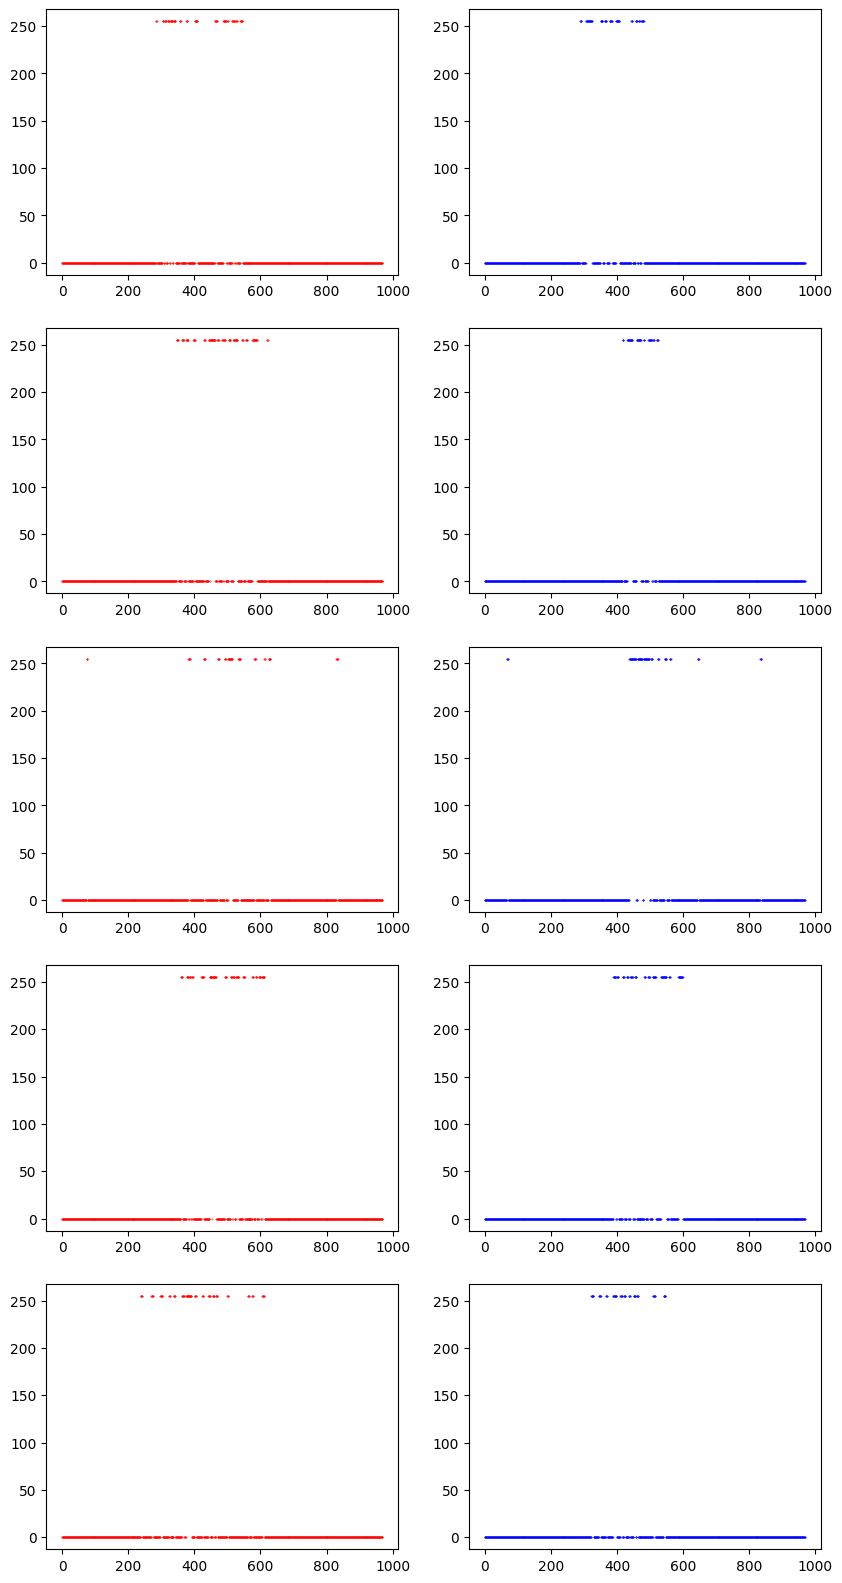

In [199]:
diameter = get_avg_diameters(img_tops,df_angle)

In [203]:
diameter

,ind,low_count,low_diameter,high_count,high_diameter
0,0,16,5.250000,10,7.600000
1,1,16,6.687500,7,8.000000
2,2,11,5.727273,10,8.600000
3,3,16,6.187500,12,7.666667
4,4,16,5.875000,11,6.090909


In [204]:
df_diameter = df_angle.merge(diameter, on='ind', how='left')
df_diameter

,ind,top_x,top_y,layer_ind,left,right,angle,height,low_count,low_diameter,high_count,high_diameter
0,0,415,35,478,25,627,111.091144,229,16,5.250000,10,7.600000
1,1,483,37,476,276,718,98.496066,227,16,6.687500,7,8.000000
2,2,545,46,462,82,840,130.651801,213,11,5.727273,10,8.600000
3,3,489,17,456,302,658,86.196326,207,16,6.187500,12,7.666667
4,4,444,7,429,176,666,109.228304,180,16,5.875000,11,6.090909


In [302]:
# get the lateral root angle 
def get_lateral_angle(img_tops,df_diameter):
    df = pd.DataFrame()
        
    for i in range(len(img_tops)): #
        half_height = df_diameter['top_y'][i] + int((df_diameter['height'][i]-df_diameter['top_y'][i])/2)
        middle_row = img_tops[i][half_height,:,0]
        # get the center pixel index of each 255 cluster
        key_func = lambda x: x==255 
        length = 0
        center_pixels=[]
        for key, group in groupby(middle_row, key_func): 
            #print(str(key) + " :",)# list(group)) 
            #print(group)
            
            if key:
                center_pixel = length + int(len(list(group))/2)
                center_pixels.append(center_pixel)
            length = length + len(list(group))
        
        angles = []
        for j in range(len(center_pixels)):
            vector_left = (half_height - df_layer['top_y'][i], center_pixels[j] - df_layer['top_x'][i])
            vector_right = (half_height - df_layer['top_y'][i], 0)
            angle = abs(math.degrees(math.atan2(vector_right[1], vector_right[0]) - math.atan2(vector_left[1], vector_left[0])))
            angles.append(angle)
        avg_angle = np.mean(angles)
        df = pd.concat([df,pd.DataFrame([{'ind':i,'avg_angle':avg_angle}])],ignore_index=True)
            
    return df
        

In [304]:
avg_angle = get_lateral_angle(img_tops,df_diameter)
avg_angle

,ind,avg_angle
0,0,29.390290
1,1,26.144911
2,2,47.215618
3,3,31.021114
4,4,41.189863


In [305]:
df_avg_angle = df_diameter.merge(avg_angle, on='ind', how='left')
df_avg_angle

,ind,top_x,top_y,layer_ind,left,right,angle,height,low_count,low_diameter,high_count,high_diameter,avg_angle
0,0,415,35,478,25,627,111.091144,229,16,5.250000,10,7.600000,29.390290
1,1,483,37,476,276,718,98.496066,227,16,6.687500,7,8.000000,26.144911
2,2,545,46,462,82,840,130.651801,213,11,5.727273,10,8.600000,47.215618
3,3,489,17,456,302,658,86.196326,207,16,6.187500,12,7.666667,31.021114
4,4,444,7,429,176,666,109.228304,180,16,5.875000,11,6.090909,41.189863


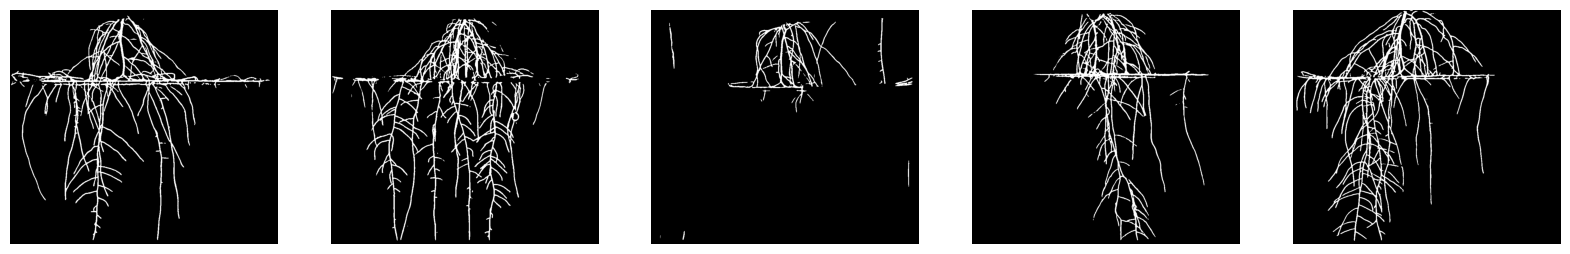

In [306]:
# display segmentation for reference
display_images(raw_images)